## North Classifier

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)

In [34]:
wind_array = np.array(data_wind['sfcWind'])
rain_array = np.array(data_rain['rainfall'])
tas_array = np.array(data_temp['tas'])
lat = np.array(data_temp['latitude'])


northern_lat_threshold = 54.0
northern_lat_index = np.where(lat >= northern_lat_threshold)[0][0]

In [19]:
num_years_temp = 1668 // 12
temp_reshaped = tas_array[:num_years_temp * 12].reshape(num_years_temp, 12, -1)  

temp_mean_north = temp_reshaped[:, 0, northern_lat_index:]
temp_north = temp_mean_north.flatten()

In [20]:
num_years = 2244 // 12
rain_reshaped = rain_array[:num_years * 12].reshape(num_years, 12, -1)  

rain_mean_north = rain_reshaped[:, 0, northern_lat_index:]
rain_north = rain_mean_north.flatten()

In [21]:
num_years = 648 // 12
wind_reshaped = wind_array[:num_years * 12].reshape(num_years, 12, -1)  

wind_mean_north = wind_reshaped[:, 0, northern_lat_index:]
wind_north = wind_mean_north.flatten()

In [41]:
min_length = len(wind_north)
temp_north = temp_north[:min_length]
rain_north = rain_north[:min_length]
print(len(wind_north), len(rain_north), len(temp_north))

493398 493398 493398


In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
temp_north = scaler.fit_transform(temp_north.reshape(-1, 1)).flatten()
rain_north = scaler.fit_transform(rain_north.reshape(-1, 1)).flatten()
wind_north = scaler.fit_transform(wind_north.reshape(-1, 1)).flatten()

# Assuming temp, temp_max, and temp_min have shape (num_years, x, y)
num_years_temp, x, y = tas_array.shape

# Create an array of years to match the reshaped temperature arrays
years_expanded = np.repeat(np.arange(1969, 2023), x * y)
years_expanded = years_expanded[:min_length]
print(len(years_expanded))
data_dict = {
    'Year': years_expanded,
    'Temperature': temp_north,
    'Rainfall': rain_north,
    'Wind Speed': wind_north
}

print(num_years_temp)
print(len(wind_north), len(rain_north), len(temp_north))

493398
1668
493398 493398 493398


In [43]:
import pandas as pd

df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

      Temperature  Rainfall  Wind Speed      Class
Year                                              
1969     0.768917  0.283928    0.311271   pre_1990
1969     0.759933  0.227176    0.169835   pre_1990
1969     0.641646  0.040403    0.198970   pre_1990
1969     0.630654  0.062847    0.149062   pre_1990
1969     0.619131  0.127513    0.131135   pre_1990
...           ...       ...         ...        ...
2022     0.601418  0.043422    0.146756  post_1990
2022     0.560316  0.063686    0.234217  post_1990
2022     0.585166  0.096840    0.188305  post_1990
2022     0.619536  0.089564    0.136348  post_1990
2022     0.618149  0.096189    0.161153  post_1990

[92097 rows x 4 columns]


In [46]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import sem
from scipy.stats import t

X = df[['Temperature','Rainfall', 'Wind Speed']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

# Training set score
train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

# Test set score
test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")

scores = cross_val_score(knn, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)

0.6431053203040173
              precision    recall  f1-score   support

   post_1990       0.70      0.74      0.72     11296
    pre_1990       0.54      0.49      0.52      7124

    accuracy                           0.64     18420
   macro avg       0.62      0.62      0.62     18420
weighted avg       0.64      0.64      0.64     18420

Training Set Score: 0.8051
Test Set Score: 0.6431
Average Accuracy: 0.5643
95% Confidence Interval: (0.5171174265598389, 0.6115625532018892)


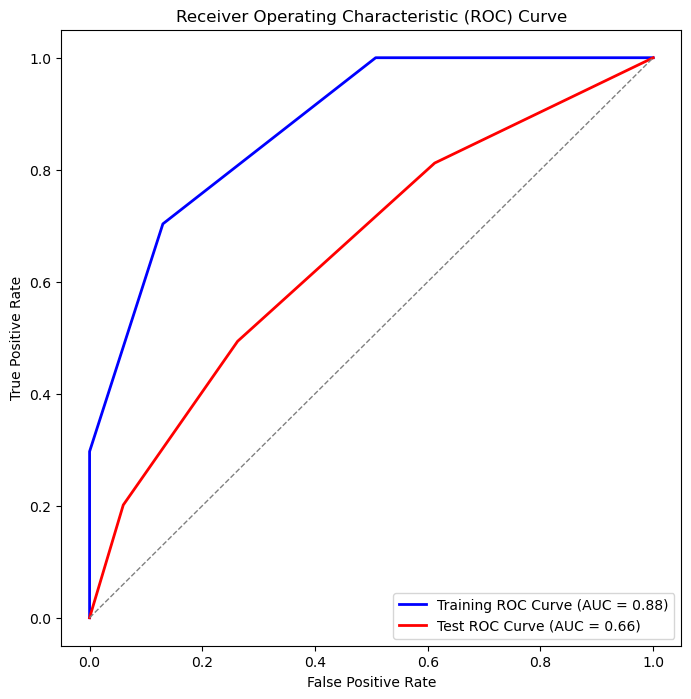

In [47]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

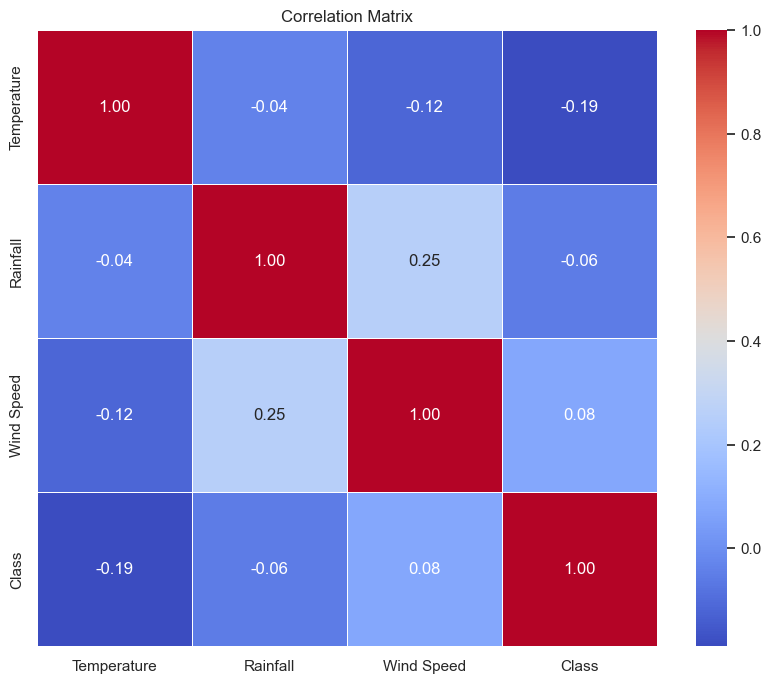

In [49]:
import seaborn as sns
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

correlation_matrix = df.corr()
sns.set(style="white")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

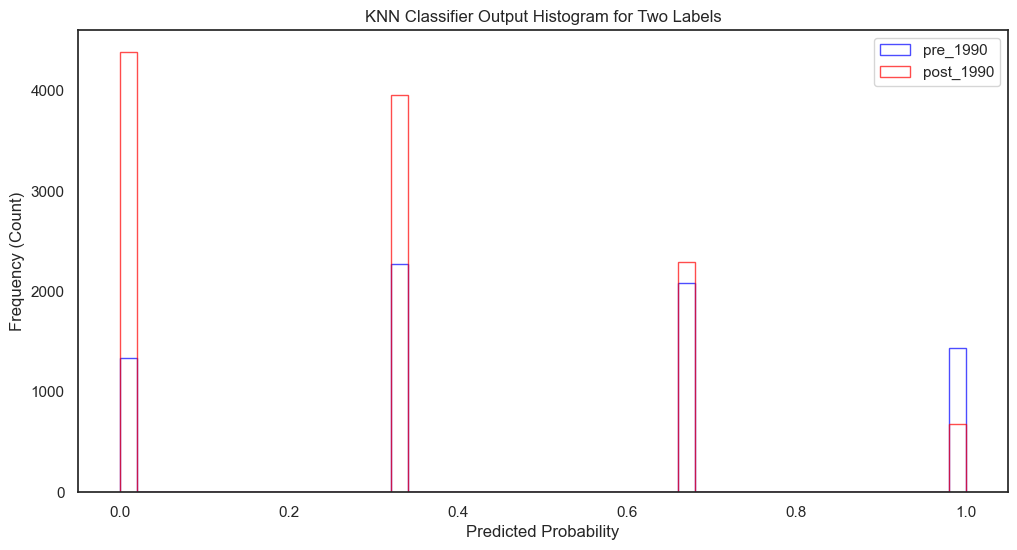

In [50]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

# Specify the two labels for which you want to create histograms
label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')

plt.title('KNN Classifier Output Histogram for Two Labels')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()

## South Classifier

In [58]:
southern_lat_threshold = 54.0

# Find the index where latitude crosses the threshold
southern_lat_index = np.where(lat <= southern_lat_threshold)[0][0]

In [59]:
num_years_temp = 1668 // 12
temp_reshaped = tas_array[:num_years_temp * 12].reshape(num_years_temp, 12, -1)  

temp_mean_south = temp_reshaped[:, 0, southern_lat_index:]
temp_south = temp_mean_south.flatten()

In [60]:
num_years = 2244 // 12
rain_reshaped = rain_array[:num_years * 12].reshape(num_years, 12, -1)  

rain_mean_south = rain_reshaped[:, 0, southern_lat_index:]
rain_south = rain_mean_south.flatten()

In [61]:
num_years = 648 // 12
wind_reshaped = wind_array[:num_years * 12].reshape(num_years, 12, -1)  

wind_mean_south = wind_reshaped[:, 0, southern_lat_index:]
wind_south = wind_mean_south.flatten()

In [62]:
min_length = len(wind_south)
temp_south = temp_south[:min_length]
rain_south = rain_south[:min_length]
print(len(wind_south), len(rain_south), len(temp_south))

495936 495936 495936


In [63]:
scaler = MinMaxScaler()
temp_south = scaler.fit_transform(temp_south.reshape(-1, 1)).flatten()
rain_south = scaler.fit_transform(rain_south.reshape(-1, 1)).flatten()
wind_south = scaler.fit_transform(wind_south.reshape(-1, 1)).flatten()

# Assuming temp, temp_max, and temp_min have shape (num_years, x, y)
num_years_temp, x, y = tas_array.shape

# Create an array of years to match the reshaped temperature arrays
years_expanded = np.repeat(np.arange(1969, 2023), x * y)
years_expanded = years_expanded[:min_length]
print(len(years_expanded))
data_dict = {
    'Year': years_expanded,
    'Temperature': temp_south,
    'Rainfall': rain_south,
    'Wind Speed': wind_south
}

print(num_years_temp)
print(len(wind_south), len(rain_south), len(temp_south))

495936
1668
495936 495936 495936


In [64]:
df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

      Temperature  Rainfall  Wind Speed      Class
Year                                              
1969     0.603066  0.070871    0.184445   pre_1990
1969     0.585156  0.131948    0.167425   pre_1990
1969     0.555321  0.175152    0.184417   pre_1990
1969     0.681379  0.337684    0.153028   pre_1990
1969     0.641493  0.368395    0.155257   pre_1990
...           ...       ...         ...        ...
2022     0.638714  0.058748    0.194311  post_1990
2022     0.702459  0.023844    0.125845  post_1990
2022     0.728302  0.017685    0.099425  post_1990
2022     0.706353  0.023184    0.112540  post_1990
2022     0.627973  0.122300    0.222295  post_1990

[92097 rows x 4 columns]


In [65]:

X = df[['Temperature','Rainfall', 'Wind Speed']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

# Training set score
train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

# Test set score
test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")

scores = cross_val_score(knn, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)

0.6428881650380022
              precision    recall  f1-score   support

   post_1990       0.70      0.73      0.72     11297
    pre_1990       0.54      0.50      0.52      7123

    accuracy                           0.64     18420
   macro avg       0.62      0.62      0.62     18420
weighted avg       0.64      0.64      0.64     18420

Training Set Score: 0.8066
Test Set Score: 0.6429
Average Accuracy: 0.5653
95% Confidence Interval: (0.5200450319668848, 0.6104809491180061)


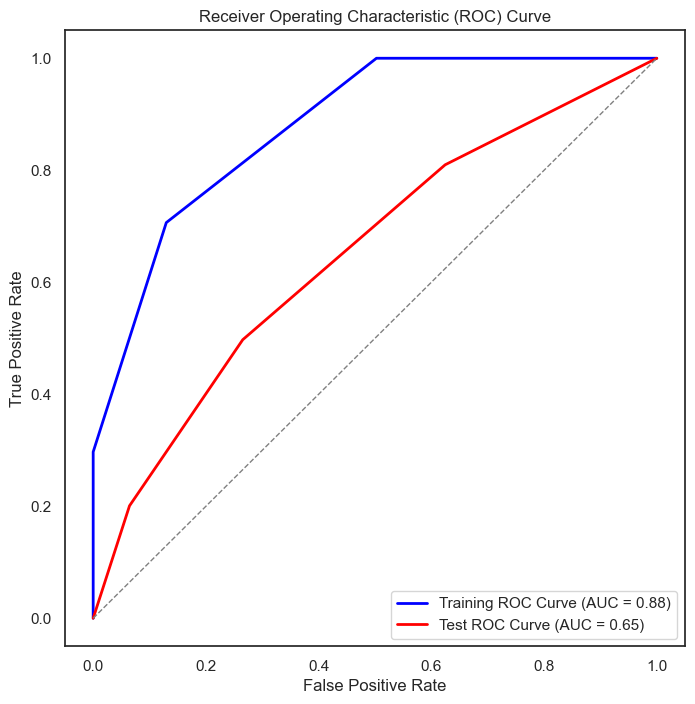

In [66]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

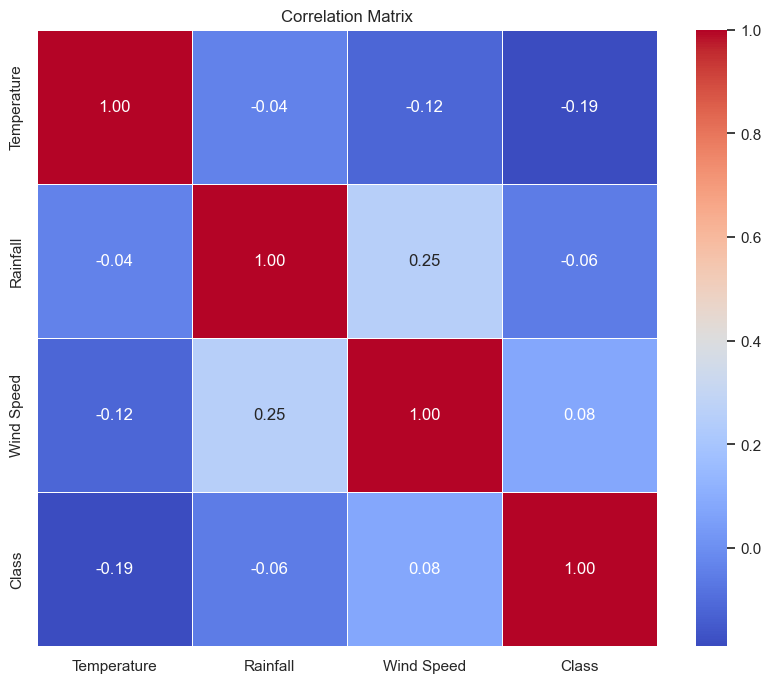

In [67]:
import seaborn as sns
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

correlation_matrix = df.corr()
sns.set(style="white")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

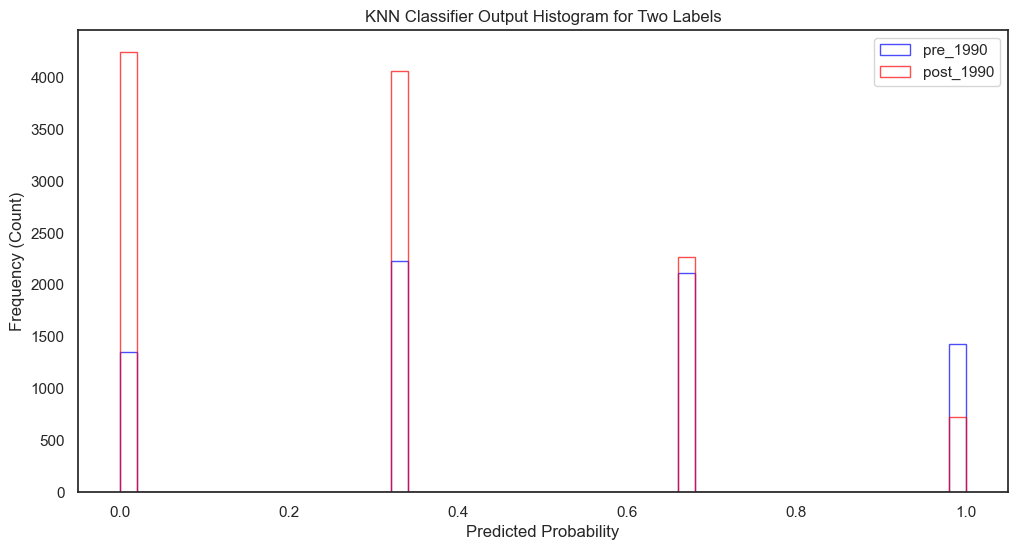

In [68]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

# Specify the two labels for which you want to create histograms
label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')

plt.title('KNN Classifier Output Histogram for Two Labels')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()